#### UNet architecture class

In [1]:
import torch.nn as nn
import torch

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        
        # Regularization to reduce overfitting
        self.dropout = nn.Dropout2d(p=0.5)
        
       
        # ENCODER
        # customize each layer of double conv
        self.down_conv_1 = self.doubleConv(1,64)
        self.down_conv_2 = self.doubleConv(64,128)
        self.down_conv_3 = self.doubleConv(128,256)
        self.down_conv_4 = self.doubleConv(256,512)
        self.down_conv_5 = self.doubleConv(512,1024)
        
        # DECODER
        self.up_conv_1 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=(2,2), stride=(2,2))
        self.up_conv_2 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=(2,2), stride=(2,2))
        self.up_conv_3 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=(2,2), stride=(2,2))
        self.up_conv_4 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=(2,2), stride=(2,2))
        
        self.down_conv_6 = self.doubleConv(1024,512)
        self.down_conv_7 = self.doubleConv(512,256)
        self.down_conv_8 = self.doubleConv(256,128)
        self.down_conv_9 = self.doubleConv(128,64)

        self.down_conv_final = nn.Conv2d(in_channels=64, out_channels=2, kernel_size=(1,1))
        
    def doubleConv(self, in_c, out_c):
        conv = nn.Sequential(
            nn.Conv2d(in_channels=in_c, out_channels=out_c, kernel_size=(3,3)),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=out_c, out_channels=out_c, kernel_size=(3,3)),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True)
        )
        return conv
    
    def cropping(self, ori_tensor, target_tensor):
        # assuming image is perfect square
        ori_tensor_width = ori_tensor.shape[3]
        target_tensor_width = target_tensor.shape[3]
        delta = ori_tensor_width - target_tensor_width
        delta = delta // 2 # assume perfect square
        return ori_tensor[:,:,delta:ori_tensor_width-delta, delta:ori_tensor_width-delta]
    
    def forward(self, x):
        # encoder
        x1 = self.down_conv_1(x)# output got concatenated
        x2 = self.maxpool(x1)
        x2 = self.dropout(x2)
        x3 = self.down_conv_2(x2)# output got concatenated
        x4 = self.maxpool(x3)
        x4 = self.dropout(x4)
        x5 = self.down_conv_3(x4)# output got concatenated
        x6 = self.maxpool(x5)
        x6 = self.dropout(x6)
        x7 = self.down_conv_4(x6)# output got concatenated
        x8 = self.maxpool(x7)
        x8 = self.dropout(x8)
        x9 = self.down_conv_5(x8)
        
        # decoder
        x10 = self.up_conv_1(x9)
        x10 = self.dropout(x10)
        x11 = torch.cat((x10,self.cropping(x7,x10)), dim=1)

        x12 = self.down_conv_6(x11)

        x13 = self.up_conv_2(x12)
        x13 = self.dropout(x13)
        x14 = torch.cat((x13,self.cropping(x5,x13)), dim=1)

        x15 = self.down_conv_7(x14)

        x16 = self.up_conv_3(x15)
        x16 = self.dropout(x16)
        x17 = torch.cat((x16,self.cropping(x3,x16)), dim=1)

        x18 = self.down_conv_8(x17)

        x19 = self.up_conv_4(x18)
        x19 = self.dropout(x19)
        x20 = torch.cat((x19,self.cropping(x1,x19)), dim=1)

        x21 = self.down_conv_9(x20)

        x22 = self.down_conv_final(x21)
        return x22
        
        

#### MultiInputNet architecture class

In [2]:
class MultiInputNet(nn.Module):
    def __init__(self, landmark_input_size=64, landmark_output_size=32):
        super().__init__()
        
        # image pathway (Dense UNet)
        self.u_net = UNet()
        self.u_net = self.u_net.to(device)
        
        # landmark pathway
        self.landmark_input_size = landmark_input_size
        self.landmark_output_size = landmark_output_size
        self.landmark_fc = nn.Linear(self.landmark_input_size, self.landmark_output_size)
        
        # combined pathway
        # based on (c,h,w), output unet is (2,388,388) and output landmarks ffn is (1,1,64)  
        combined_input = 2*388*388 + 1*self.landmark_output_size
        self.combined_fc = nn.Linear(combined_input, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 3)

        
        # dropout feed forward for regularization
        self.dropout = nn.Dropout(0.45)  # Dropout layer with dropout rate of 0.4

        # activation fn
        self.relu = nn.ReLU()
        
        # batchnorm
        self.bn_landmark_fc = nn.BatchNorm1d(self.landmark_output_size)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(32)
    
    def forward(self, image, landmark):
        # unet process
        image_features = self.u_net(image)
        # landmark process
        landmark_features = self.landmark_fc(landmark)
        landmark_features = self.bn_landmark_fc(landmark_features)
        landmark_features = self.relu(landmark_features)
        landmark_features = self.dropout(landmark_features)
        
        # combined features
        # img_b4_flat = image_features
        # land_b4_flat = landmark_features
        # print("Image before flatten ", img_b4_flat.shape)
        # print("landmark before flatten ", land_b4_flat.shape)
        
        # flatten both tensor before concatenating, exclude batch_size in BCHW, only flatten CHW
        flatten_img = torch.flatten(image_features, start_dim=1) 
        flatten_land = torch.flatten(landmark_features, start_dim=1)
        
        # print("Image after flatten ", flatten_img.shape)
        # print("landmark after flatten ", flatten_land.shape)

        combined_features = torch.cat((flatten_img,flatten_land), dim=1)
        # print("Combined_features ", combined_features.shape)
        
        x = self.combined_fc(combined_features)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc3(x)
        
        return x

#### Define cuda

In [3]:
# Move the model to CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Import training and test dataset from .csv

In [4]:
import pandas as pd
import time

In [5]:
# Load training data
dataset_training_csv_path = 'C:\\Users\\iqmal_pc\\Desktop\\fyp_experiment\\training_dataset\\angles_ap_labelled_training.csv'
dataset_training_csv = pd.read_csv(dataset_training_csv_path)
dataset_training_csv

,PT,MT,TL/L,image_training_file,cobb_angle_training_file
0,6.2069,0.00000,1.261400,sunhl-1th-02-Jan-2017-162 A AP.jpg,sunhl-1th-02-Jan-2017-162 A AP.jpg.mat
1,23.8107,0.00000,0.851886,sunhl-1th-02-Jan-2017-162 B AP.jpg,sunhl-1th-02-Jan-2017-162 B AP.jpg.mat
2,21.1172,0.00000,0.000000,sunhl-1th-03-Jan-2017-163 A AP.jpg,sunhl-1th-03-Jan-2017-163 A AP.jpg.mat
3,10.8144,8.60388,0.000000,sunhl-1th-03-Jan-2017-163 B AP.jpg,sunhl-1th-03-Jan-2017-163 B AP.jpg.mat
4,18.1538,0.00000,1.748480,sunhl-1th-03-Jan-2017-164 A AP.jpg,sunhl-1th-03-Jan-2017-164 A AP.jpg.mat
...,...,...,...,...,...
476,12.5325,0.00000,11.484000,sunhl-1th-30-Dec-2016-159 A AP2.jpg,sunhl-1th-30-Dec-2016-159 A AP2.jpg.mat
477,11.0118,10.37890,0.000000,sunhl-1th-30-Dec-2016-159 B AP.jpg,sunhl-1th-30-Dec-2016-159 B AP.jpg.mat
478,5.6424,3.95370,2.821400,sunhl-1th-30-Dec-2016-159 C AP.jpg,sunhl-1th-30-Dec-2016-159 C AP.jpg.mat
479,16.3437,0.00000,0.000000,sunhl-1th-30-Dec-2016-160 A AP.jpg,sunhl-1th-30-Dec-2016-160 A AP.jpg.mat


In [6]:
# Load test data
dataset_test_csv_path = 'C:\\Users\\iqmal_pc\\Desktop\\fyp_experiment\\test_dataset\\angles_ap_labelled_test.csv'
dataset_test_csv = pd.read_csv(dataset_test_csv_path)
dataset_test_csv

,PT,MT,TL/L,image_test_file,cobb_angle_test_file
0,12.5578,0.00000,0.938543,sunhl-1th-01-Mar-2017-310 C AP.jpg,sunhl-1th-01-Mar-2017-310 C AP.jpg.mat
1,7.4942,1.00940,0.000000,sunhl-1th-01-Mar-2017-310 a ap.jpg,sunhl-1th-01-Mar-2017-310 a ap.jpg.mat
2,14.0048,0.00000,0.501069,sunhl-1th-01-Mar-2017-311 A AP.jpg,sunhl-1th-01-Mar-2017-311 A AP.jpg.mat
3,13.3802,0.00000,1.422200,sunhl-1th-01-Mar-2017-311 C AP.jpg,sunhl-1th-01-Mar-2017-311 C AP.jpg.mat
4,16.1798,1.23238,0.000000,sunhl-1th-01-Mar-2017-311 D AP.jpg,sunhl-1th-01-Mar-2017-311 D AP.jpg.mat
...,...,...,...,...,...
123,7.8933,0.00000,1.726000,sunhl-1th-28-Feb-2017-307 B AP.jpg,sunhl-1th-28-Feb-2017-307 B AP.jpg.mat
124,22.5108,0.00000,14.726900,sunhl-1th-28-Feb-2017-308 A AP.jpg,sunhl-1th-28-Feb-2017-308 A AP.jpg.mat
125,9.3330,0.73155,6.376700,sunhl-1th-28-Feb-2017-309 A AP.jpg,sunhl-1th-28-Feb-2017-309 A AP.jpg.mat
126,17.5526,8.90332,1.856840,sunhl-1th-28-Feb-2017-309 B AP.jpg,sunhl-1th-28-Feb-2017-309 B AP.jpg.mat


#### Prepare dictionary for training image data and its Cobb angle

In [7]:
training_dataset_dict = {} # good approach to maintain image - target_angle relation

# get train image list and its path
training_image_path = 'C:\\Users\\iqmal_pc\\Desktop\\fyp_experiment\\data\\training\\'

# get list of keys ie filepath
training_image_filepath_key = dataset_training_csv['image_training_file'].values.tolist()

# get list of values for dict
training_cobb_angle_values = dataset_training_csv[['PT', 'MT', 'TL/L']].values

# add to dictionary
for i in range(len(training_image_filepath_key)):
    training_dataset_dict[training_image_path + training_image_filepath_key[i]] = torch.tensor(training_cobb_angle_values[i], dtype=torch.float32)

#### Prepare dictionary for test image data and its Cobb angle

In [8]:
test_dataset_dict = {}
test_image_path = 'C:\\Users\\iqmal_pc\\Desktop\\fyp_experiment\\data\\test\\'
test_image_filepath_key = dataset_test_csv['image_test_file'].values.tolist()
test_cobb_angle_values = dataset_test_csv[['PT', 'MT', 'TL/L']].values

for i in range(len(test_image_filepath_key)):
    test_dataset_dict[test_image_path + test_image_filepath_key[i]] = torch.tensor(test_cobb_angle_values[i], dtype=torch.float32)

#### Prepare dictionary for training landmarks_ap

In [9]:
path_landmark_ap_training = "C:\\Users\\iqmal_pc\\Desktop\\fyp_experiment\\training_dataset\\"
landmark_ap_training = pd.read_csv(path_landmark_ap_training + "landmarks_ap.csv", header=None)
training_landmark_ap_key = landmark_ap_training.iloc[:,0].values.tolist()
training_landmark_ap_values = landmark_ap_training.iloc[:,2:].values.tolist()


In [10]:
training_landmark_ap_dict = {} # key->image filepath, value->62 landmarks value

for i in range(len(training_landmark_ap_key)):
    training_landmark_ap_dict[training_image_path + training_landmark_ap_key[i]] = torch.tensor(training_landmark_ap_values[i], dtype=torch.float32)

#### Prepare dictionary for test landmarks_ap

In [11]:
path_landmark_ap_test = "C:\\Users\\iqmal_pc\\Desktop\\fyp_experiment\\test_dataset\\"
landmark_ap_test = pd.read_csv(path_landmark_ap_test + "landmarks_ap.csv", header=None)
test_landmark_ap_key = landmark_ap_test.iloc[:,0].values.tolist()
test_landmark_ap_values = landmark_ap_test.iloc[:,2:].values.tolist()


In [12]:
test_landmark_ap_dict = {} # key->image filepath, value->62 landmarks value

for i in range(len(test_landmark_ap_key)):
    test_landmark_ap_dict[test_image_path + test_landmark_ap_key[i]] = torch.tensor(test_landmark_ap_values[i], dtype=torch.float32)

#### CustomDataset class

In [13]:
from torch.utils.data import Dataset
from PIL import Image, ImageOps
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor

import numpy as np

In [14]:
# create dictionary dataset where key is image path and value is PT, MT, TL/L values
class CustomDataset(Dataset):
    def __init__(self, image_list, landmark_list, cobb_angle_list, transform_image_tensor, custom_img_resize_w_h=(255,255)):
        self.images = image_list
        # convert python list of torch.tensor to torch tensor
        self.landmarks = torch.stack(landmark_list, dim=0) 
        self.cobb_angles = torch.stack(cobb_angle_list, dim=0) 
        self.transform_image_tensor = transform_image_tensor
        self.custom_img_resize_w_h = custom_img_resize_w_h
        self.mean_img = 0.0
        self.std_img = 0.0
        self.mean_cobb_angle = 0.0
        self.std_cobb_angle = 0.0
        self.mean_landmark = 0.0
        self.std_landmark = 0.0
        
        self.calculate_mean_std_img()
        self.calculate_mean_std_cobb_angle()
        self.calculate_mean_std_landmark()

        # normalize dataset once
        self.cobb_angles = (self.cobb_angles - self.mean_cobb_angle)/self.std_cobb_angle
        self.landmarks = (self.landmarks - self.mean_landmark)/self.std_landmark

        
    def __getitem__(self, index):
        image_path = self.images[index] # image_path is the key
        
        image = Image.open(image_path).convert('L')
        
        # custom resize image while maintaining aspect ratio
        image = self.resize_with_padding(image, self.custom_img_resize_w_h)
        
        # calculate mean and std of entire images
        z_norm_img = transforms.Normalize(self.mean_img, self.std_img)
        
        # transform image if required
        if self.transform_image_tensor is not None:
            image = self.transform_image_tensor(image)
            image = torch.permute(image, dims=(0,2,1)) # convert PIL (w,h) to tensor (h,w)
            image = z_norm_img(image)
            
        # transform ie normalize cobb_angle
        # z_norm_cobb_angle = transforms.Normalize(self.mean_cobb_angle, self.std_cobb_angle)
        # self.cobb_angles = z_norm_cobb_angle(self.cobb_angles)
        # self.cobb_angles = (self.cobb_angles - self.mean_cobb_angle)/self.std_cobb_angle
        
        # transform ie normalize landmark
        # z_norm_landmark = transforms.Normalize(self.mean_landmark, self.std_landmark)
        # self.landmark = z_norm_landmark(self.landmarks)
        # self.landmarks = (self.landmarks - self.mean_landmark)/self.std_landmark
        

        # because U-net is hardcoded for 3 channel, duplicate another 2 channel
        # image = torch.cat((image[:,:,:], image[:,:,:], image[:,:,:]), dim=0)
        
        return image, self.landmarks[index], self.cobb_angles[index], image_path
    
    def __len__(self):
        return len(self.images)
    
    def resize_with_padding(self, image, output_size):
        original_width, original_height = image.size
        target_width, target_height = output_size

        # Calculate aspect ratios
        aspect_ratio = original_width / original_height
        target_ratio = target_width / target_height

        # Calculate the new dimensions while maintaining aspect ratio
        if aspect_ratio > target_ratio:
            new_width = target_width
            new_height = int(new_width / aspect_ratio)
        else:
            new_height = target_height
            new_width = int(new_height * aspect_ratio)

        # Resize the image while preserving the aspect ratio
        resized_image = image.resize((new_width, new_height), resample=Image.Resampling.LANCZOS)

        # Create a new image with the target size and paste the resized image onto it
        padded_image = Image.new('L', (target_width, target_height))
        x_offset = (target_width - new_width) // 2
        y_offset = (target_height - new_height) // 2
        padded_image.paste(resized_image, (x_offset, y_offset))

        return padded_image
    
    def calculate_mean_std_img(self):
        num_images = len(self.images)
        mean_list = np.zeros((num_images,))
        std_list = np.zeros((num_images,))
        
        for i in range(num_images):
            image_path = self.images[i]
            image = Image.open(image_path).convert('L')
            image = self.resize_with_padding(image, self.custom_img_resize_w_h)
            
            image_tensor = ToTensor()(image)
            image_tensor = torch.permute(image_tensor, dims=(0,2,1)) # convert PIL (w,h) to tensor (h,w)
            
            mean_list[i] = torch.mean(image_tensor)
            std_list[i] = torch.std(image_tensor)

        # calculate combined std
        var_list = np.array([element**2 for element in std_list])
        combined_std = np.sqrt(np.sum(var_list)/std_list.shape[0])
        self.std_img = combined_std # result output
        
        # calculate combined mean
        combined_mean = np.mean(mean_list)
        self.mean_img = combined_mean # result output
        
    def calculate_mean_std_cobb_angle(self):
        num_cobb_angle = self.cobb_angles.shape[0]
        PT_values_list = np.zeros((num_cobb_angle,))
        MT_values_list = np.zeros((num_cobb_angle,))
        TL_values_list = np.zeros((num_cobb_angle,))
        
        
        for i in range(num_cobb_angle):
            PT_values_list[i] = self.cobb_angles[i][0]
            MT_values_list[i] = self.cobb_angles[i][1]
            TL_values_list[i] = self.cobb_angles[i][2]
            
        
        PT_mean = np.mean(PT_values_list)
        MT_mean = np.mean(MT_values_list)
        TL_mean = np.mean(TL_values_list)
        
        PT_std = np.std(PT_values_list)
        MT_std = np.std(MT_values_list)
        TL_std = np.std(TL_values_list)
        
        #calculate combined std
        var_list = np.array([PT_std**2, MT_std**2, TL_std**2])
        combined_std = np.sqrt(np.sum(var_list)/3)
        self.std_cobb_angle = combined_std
        
        # calculate combined mean
        combined_mean = np.mean([PT_mean,MT_mean,TL_mean])
        self.mean_cobb_angle = combined_mean
        
        print('std_cobb_angle ', combined_std)
        print('mean_cobb_angle ', combined_mean)
        
    def calculate_mean_std_landmark(self):
        # torch_landmark = torch.stack(self.landmarks, dim=0) # convert list to tensor
        mean_list = torch.mean(self.landmarks, dim=0) # row collapse to calculate each column mean
        std_list = torch.std(self.landmarks, dim=0) # row collapse to calculate each column std
        
        # calculate combined std
        var_list = torch.tensor([element**2 for element in std_list])
        combined_std = torch.sqrt(torch.sum(var_list)/std_list.shape[0])
        self.std_landmark = combined_std
        
        # calculate combined mean
        combined_mean = torch.mean(mean_list)
        self.mean_landmark = combined_mean

#### Tensor Transformations

In [15]:
# # calculate mean and standard deviation for entire image_dataset

# import numpy as np
# # open all training images and put them in 1 numpy block
# all_images_path = list(training_dataset_dict.keys())
# images_training = np.zeros((len(all_images_path,)), dtype=object)

# for i in range(len(all_images_path)):
#     img = Image.open(all_images_path[i]).convert('L')
#     images_training[i] = np.asarray(img, dtype=np.float32)
    
# # print(images)

# mean_training = np.mean(images_training)
# std_training = np.std(images_training)

# print('mean is ', mean_training)
# print('std is ', std_training)

In [16]:
transform_images_tensor = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.type(torch.float32))
])

#### Train-Validation split

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
# transform to list before inputting into splitting function
training_image_list = list(training_dataset_dict.keys())
training_landmark_list = list(training_landmark_ap_dict.values())
training_true_cobb_angle_list = list(training_dataset_dict.values())

In [19]:
# Split the lists into training and validation sets
training_image, val_image, training_landmark, val_landmark, training_true_cobb_angle, val_true_cobb_angle = train_test_split(training_image_list, training_landmark_list, training_true_cobb_angle_list, test_size=0.2, random_state=42)

#### Custom Dataset instance for training and validation

In [20]:
print('transformed_training_dataset')
transformed_training_dataset = CustomDataset(training_image, training_landmark, training_true_cobb_angle, transform_images_tensor, (572,572))
print('transformed_validation_dataset')
transformed_validation_dataset = CustomDataset(val_image, val_landmark, val_true_cobb_angle, transform_images_tensor, (572,572))

transformed_training_dataset
std_cobb_angle  3.2215509395355943
mean_cobb_angle  5.493506302859815
transformed_validation_dataset
std_cobb_angle  3.4379941274198913
mean_cobb_angle  5.729382691079194


In [21]:
# _, landmark, cobb, path = transformed_training_dataset.__getitem__(2)
# print('cobb ', cobb)
# print('imgfile ', path)

#### training_loader and validation_loader

In [22]:
from torch.utils.data import DataLoader
# Create a data loader for batching and shuffling the data
# batch_size = 32

training_loader = DataLoader(transformed_training_dataset, batch_size=2, shuffle=True)
validation_loader =  DataLoader(transformed_validation_dataset, batch_size=1, shuffle=False)

In [23]:
# # scractcpad
# model_try = MultiInputNet(landmark_input_size=64, landmark_output_size=64)
# model_try.to(device)
# for img, land, target, imagepath in training_loader:
#     img = img.to(device)
#     land = land.to(device)
#     target = target.to(device)
#     print('imagepath ', imagepath)
#     print('target angle ', target)
#     predicted = model_try(img, land)
#     print('predicted ', predicted)

#### Training and validating process

In [24]:
import torch.optim as optim
import copy

In [25]:
model = MultiInputNet(landmark_input_size=64)
model = model.to(device)

In [26]:
# set up optimizer and loss function
base_lr = 0.1
num_epochs = 50
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=base_lr)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, eta_min=0.0001, verbose=True)

Epoch 00000: adjusting learning rate of group 0 to 1.0000e-01.


In [27]:
# to save validation loss and training loss
loss_list_data = []
val_acc = []
lr = []

# to keep track lowest loss
lowest_val_loss = float('inf')

start_time = time.time()

# training loop with validation
for epoch in range(num_epochs):
    
    # training phase
    model.train()                                       # allow weights and biases adjusting
    training_loss = 0.0
    for image_input, landmark_input, target_angle, _ in training_loader:
        # move input and output to cuda if available
        image_input = image_input.to(device)
        landmark_input = landmark_input.to(device)
        target_angle = target_angle.to(device)
        optimizer.zero_grad()                           # clearing previous loss derivative
        predicted = model(image_input, landmark_input)                  # forward 
        loss = criterion(predicted, target_angle)       # computing loss
        loss.backward()                                 # computing loss derivative with respect of weights and biases
        optimizer.step()                                # adjusting weights and biases
        training_loss += loss.item()                    # summing all batches losses for averaging
    training_loss /= len(training_loader)
        
    # validation phase in at end of every epoch
    model.eval()                                        # block weights and biases adjsuting
    val_loss = 0.0
    with torch.no_grad():                                # remove all computed derivatives
        for image_input, landmark_input, target_angle, _ in validation_loader:
            # move input and output to cuda if available
            image_input = image_input.to(device)
            landmark_input = landmark_input.to(device)
            target_angle = target_angle.to(device)
            predicted = model(image_input, landmark_input)
            # for averaging validation loss
            val_loss += criterion(predicted, target_angle).item()
    
    val_loss /= len(validation_loader) # calculating average validation loss
    
    # Print the training and validation loss for each epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {training_loss}, Validation Loss: {val_loss}")    
    
    # for graphing evaluation later
    loss_list_data.append((epoch+1, training_loss, val_loss))
    
    # update learning rate
    scheduler.step()
    
    # for graphing learning rate vs epoch later
    lr.append(optimizer.param_groups[0]['lr'])
    print('Current learning rate ', scheduler.get_last_lr())
    
    # save best model with lowest validation loss
    if lowest_val_loss > val_loss:
        lowest_val_loss = val_loss
        best_model = copy.deepcopy(model.state_dict())
        
        # save the best model found
        path = 'C:\\Users\\iqmal_pc\\Desktop\\fyp_experiment\\saved_models\\training_7\\'
        torch.save(best_model, path + 'best_training_7.pt')
        print('Lowest val_loss found')
        del best_model # release memory



end_time = time.time()

Epoch [1/50], Training Loss: 1.3447693092748523, Validation Loss: 1.1886959390081082
Epoch 00001: adjusting learning rate of group 0 to 9.0460e-02.
Current learning rate  [0.09046039886902862]
Lowest val_loss found
Epoch [2/50], Training Loss: 1.0584527337147545, Validation Loss: 1.0013776753366608
Epoch 00002: adjusting learning rate of group 0 to 6.5485e-02.
Current learning rate  [0.06548539886902863]
Lowest val_loss found
Epoch [3/50], Training Loss: 1.031770064495504, Validation Loss: 1.0106073770787298
Epoch 00003: adjusting learning rate of group 0 to 3.4615e-02.
Current learning rate  [0.03461460113097138]
Epoch [4/50], Training Loss: 1.0130654765913885, Validation Loss: 1.0023898168937446
Epoch 00004: adjusting learning rate of group 0 to 9.6396e-03.
Current learning rate  [0.00963960113097138]
Epoch [5/50], Training Loss: 1.0063659397225517, Validation Loss: 1.0037100310101337
Epoch 00005: adjusting learning rate of group 0 to 1.0000e-01.
Current learning rate  [0.1]
Epoch [6

#### Compute training time

In [28]:
training_time = end_time - start_time
print("Training time elapsed: " + str(training_time) + " seconds")

Training time elapsed: 5326.474160909653 seconds


#### Save latest model

In [29]:
# save model 
path = 'C:\\Users\\iqmal_pc\\Desktop\\fyp_experiment\\saved_models\\training_7\\'
torch.save(model.state_dict(), path + 'finished_training_7.pt')

#### Testing model

In [30]:
# unpack list
test_image = list(test_dataset_dict.keys())
test_true_cobb_angle = list(test_dataset_dict.values())
test_landmark = list(test_landmark_ap_dict.values())

In [31]:
# loading test dataset
transformed_test_dataset = CustomDataset(test_image, test_landmark, test_true_cobb_angle, transform_images_tensor, (572,572))

std_cobb_angle  2.988889043938208
mean_cobb_angle  5.054406259208918


In [32]:
# testing data loader
test_loader =  DataLoader(transformed_test_dataset, batch_size=1, shuffle=False)

In [33]:
test_loss = 0.0
model.eval()
with torch.no_grad():
    for image_input, landmark_input, target_angle, _ in test_loader:
        # move input and output to cuda if available
        image_input = image_input.to(device)
        landmark_input = landmark_input.to(device)
        # reshape target_angle
        # target_angle = target_angle.reshape((3))
        target_angle = target_angle.to(device)
        predicted = model(image_input, landmark_input)
        test_loss += criterion(predicted, target_angle).item()

test_loss /= len(test_loader) # calculating average test_loss
print(f"Final model testing loss: {test_loss}")

Final model testing loss: 1.0764142433472443


In [39]:
# load best model
the_best_model = MultiInputNet(landmark_input_size=64)
the_best_model.load_state_dict(torch.load(path + 'best_training_7.pt')) # load the saved best model weights & biases dictionary
the_best_model = the_best_model.to(device)
# testing phase using best model
test_loss = 0.0
the_best_model.eval()
with torch.no_grad():
    for image_input, landmark_input, target_angle, _ in test_loader:
        # move input and output to cuda if available
        image_input = image_input.to(device)
        landmark_input = landmark_input.to(device)
        # reshape target_angle
        # target_angle = target_angle.reshape((3))
        target_angle = target_angle.to(device)
        predicted = the_best_model(image_input, landmark_input)
        test_loss += criterion(predicted, target_angle).item()

test_loss /= len(test_loader) # calculating average test_loss
print(f"Best model testing loss: {test_loss}")

Best model testing loss: 1.1629942459985614


#### Evaluation (Loss vs Epoch)

In [54]:
epoch_list = []
training_loss_list = []
validation_loss_list = []

for i in range(len(loss_list_data)):
    epoch_list.append(loss_list_data[i][0])
    training_loss_list.append(loss_list_data[i][1])
    validation_loss_list.append(loss_list_data[i][2])

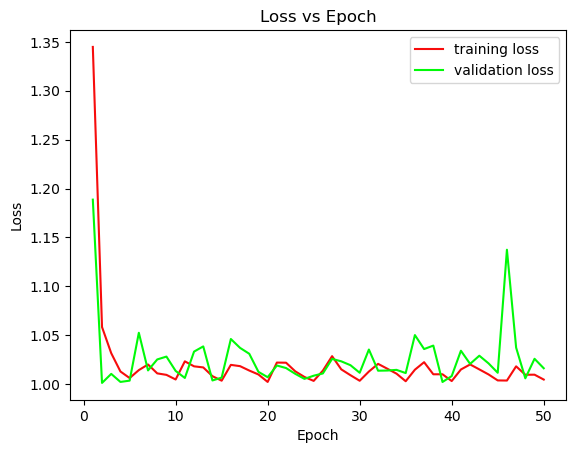

In [55]:
# plot training loss vs epoch
import matplotlib.pyplot as plt

plt.plot(epoch_list, training_loss_list, color='#f70c0c', label='training loss')
plt.plot(epoch_list, validation_loss_list, color='#00fa08', label='validation loss')
plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### learning rate vs epochs

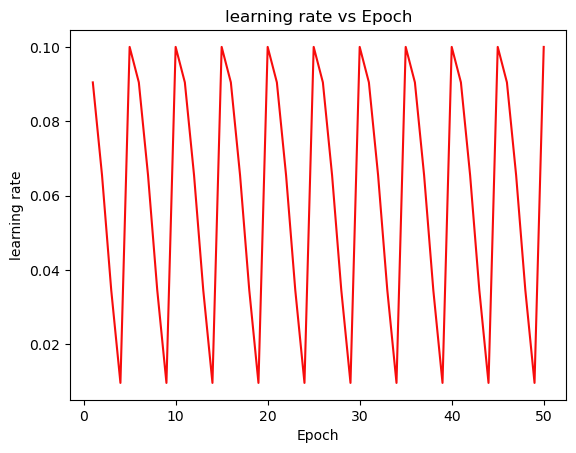

In [79]:
# plot training loss vs epoch
import matplotlib.pyplot as plt

plt.plot(epoch_list, lr, color='#f70c0c')
plt.title('learning rate vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('learning rate')
plt.show()

#### Test data evaluation plot (Predicted vs Ground Truth) for every PT, MT and TL/L using final_trained_model

In [82]:
final_trained_model = MultiInputNet(landmark_input_size=64)
final_trained_model.load_state_dict(torch.load(path + 'finished_training_7.pt')) # load the saved best model weights & biases dictionary
final_trained_model = final_trained_model.to(device)

predicted_list_final = []
target_angle_list_final = []

final_trained_model.eval()
with torch.no_grad():
    for image_input, landmark_input, target_angle, _ in test_loader:
        # move input and output to cuda if available
        image_input = image_input.to(device)
        landmark_input = landmark_input.to(device)
        target_angle = target_angle.to(device)
        predicted = the_best_model(image_input, landmark_input)
        predicted_list_final.append(predicted.cpu().numpy())
        target_angle_list_final.append(target_angle.cpu().numpy())

In [83]:
std_cobb_angle_test = 2.988889043938208
mean_cobb_angle_test = 5.054406259208918

In [84]:
# reshaping from (1,3) to (3,)
for i in range(len(predicted_list_final)):
    predicted_list_final[i] = predicted_list_final[i].reshape((3,))


In [85]:
# reshaping from (1,3) to (3,)
for i in range(len(target_angle_list_final)):
    target_angle_list_final[i] = target_angle_list_final[i].reshape((3,))


In [86]:
# combined PT (predicted, true)
PT_value_final = [(PT_predicted, PT_true) for (PT_predicted,*_),(PT_true,*_) in zip(predicted_list_final,target_angle_list_final)]

# Convert x-score value to original value
for i in range(len(PT_value_final)):
    temp = list(PT_value_final[i])
    temp[0] = std_cobb_angle_test*temp[0] + mean_cobb_angle_test
    temp[1] = std_cobb_angle_test*temp[1] + mean_cobb_angle_test
    PT_value_final[i] = tuple(temp)

# PT_value

In [87]:
MT_value_final = [(MT_predicted,MT_true) for (_,MT_predicted,_),(_,MT_true,_) in zip(predicted_list,target_angle_list)]

# Convert x-score value to original value
for i in range(len(MT_value_final)):
    temp = list(MT_value_final[i])
    temp[0] = std_cobb_angle_test*temp[0] + mean_cobb_angle_test
    temp[1] = std_cobb_angle_test*temp[1] + mean_cobb_angle_test
    MT_value_final[i] = tuple(temp)

# MT_value

In [88]:
TL_value_final = [(TL_predicted,TL_true) for (*_,TL_predicted),(*_,TL_true) in zip(predicted_list,target_angle_list)]

# Convert x-score value to original value
for i in range(len(TL_value_final)):
    temp = list(TL_value_final[i])
    temp[0] = std_cobb_angle_test*temp[0] + mean_cobb_angle_test
    temp[1] = std_cobb_angle_test*temp[1] + mean_cobb_angle_test
    TL_value_final[i] = tuple(temp)

# TL_value

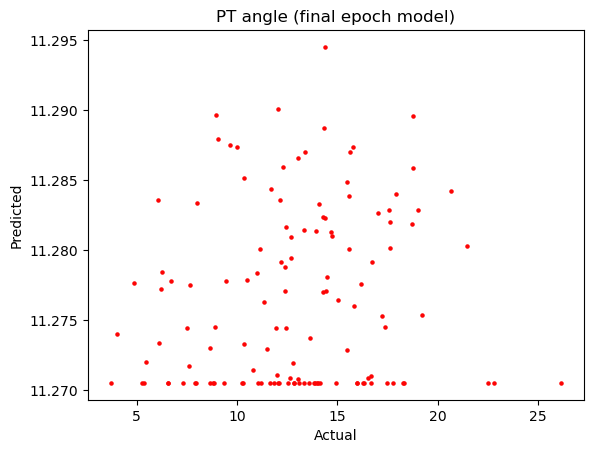

In [162]:
# plot PT value

predicted_pt = [item[0] for item in PT_value_final]
true_pt = [item[1] for item in PT_value_final]

plt.scatter(true_pt, predicted_pt, color='#fc0505', s=5)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('PT angle (final epoch model)')
plt.show()

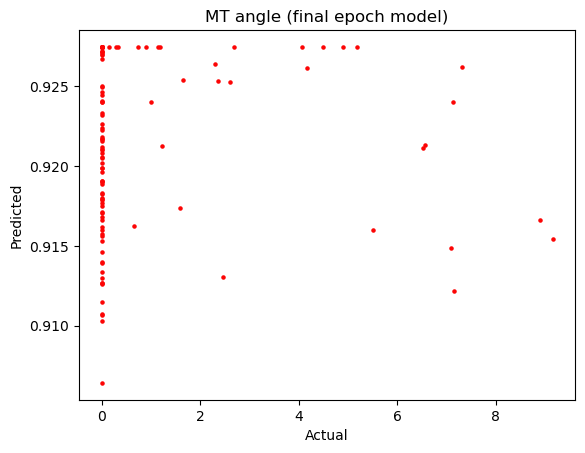

In [163]:
# plot MT value

predicted_mt = [item[0] for item in MT_value_final]
true_mt = [item[1] for item in MT_value_final]

plt.scatter(true_mt, predicted_mt, color='#fc0505', s=5)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('MT angle (final epoch model)')
plt.show()

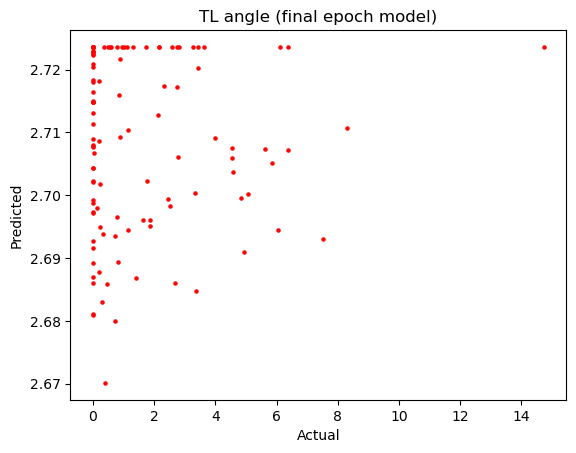

In [164]:
# plot TL value

predicted_tl = [item[0] for item in TL_value_final]
true_tl = [item[1] for item in TL_value_final]

plt.scatter(true_tl, predicted_tl, color='#fc0505', s=5)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('TL angle (final epoch model)')
plt.show()

#### Test data evaluation plot (Predicted vs Ground Truth) for every PT, MT and TL/L using the_best_model

In [92]:
predicted_list_best = []
target_angle_list_best = []

the_best_model.eval()
with torch.no_grad():
    for image_input, landmark_input, target_angle, _ in test_loader:
        # move input and output to cuda if available
        image_input = image_input.to(device)
        landmark_input = landmark_input.to(device)
        target_angle = target_angle.to(device)
        predicted = the_best_model(image_input, landmark_input)
        predicted_list_best.append(predicted.cpu().numpy())
        target_angle_list_best.append(target_angle.cpu().numpy())

In [93]:
std_cobb_angle_test = 2.988889043938208
mean_cobb_angle_test = 5.054406259208918

In [153]:
# reshaping from (1,3) to (3,)
for i in range(len(predicted_list_best)):
    predicted_list_best[i] = predicted_list_best[i].reshape((3,))


In [154]:
# reshaping from (1,3) to (3,)
for i in range(len(target_angle_list_best)):
    target_angle_list_best[i] = target_angle_list_best[i].reshape((3,))


In [155]:
# combined PT (predicted, true)
PT_value_best = [(PT_predicted, PT_true) for (PT_predicted,*_),(PT_true,*_) in zip(predicted_list_best,target_angle_list_best)]

# Convert x-score value to original value
for i in range(len(PT_value_best)):
    temp = list(PT_value_best[i])
    temp[0] = std_cobb_angle_test*temp[0] + mean_cobb_angle_test
    temp[1] = std_cobb_angle_test*temp[1] + mean_cobb_angle_test
    PT_value_best[i] = tuple(temp)

# PT_value_best

In [156]:
MT_value_best = [(MT_predicted,MT_true) for (_,MT_predicted,_),(_,MT_true,_) in zip(predicted_list_best,target_angle_list_best)]

# Convert x-score value to original value
for i in range(len(MT_value_best)):
    temp = list(MT_value_best[i])
    temp[0] = std_cobb_angle_test*temp[0] + mean_cobb_angle_test
    temp[1] = std_cobb_angle_test*temp[1] + mean_cobb_angle_test
    MT_value_best[i] = tuple(temp)

# MT_value

In [157]:
TL_value_best = [(TL_predicted,TL_true) for (*_,TL_predicted),(*_,TL_true) in zip(predicted_list_best,target_angle_list_best)]

# Convert x-score value to original value
for i in range(len(TL_value_best)):
    temp = list(TL_value_best[i])
    temp[0] = std_cobb_angle_test*temp[0] + mean_cobb_angle_test
    temp[1] = std_cobb_angle_test*temp[1] + mean_cobb_angle_test
    TL_value_best[i] = tuple(temp)

# TL_value

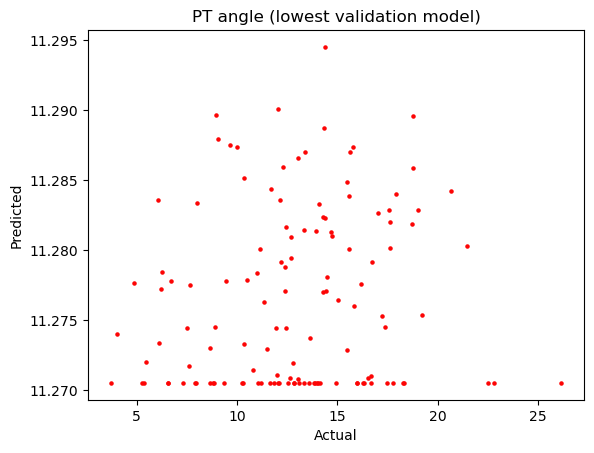

In [158]:
# plot PT value

predicted_pt = [item[0] for item in PT_value_best]
true_pt = [item[1] for item in PT_value_best]

plt.scatter(true_pt, predicted_pt, color='#fc0505', s=5)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('PT angle (lowest validation model)')
plt.show()

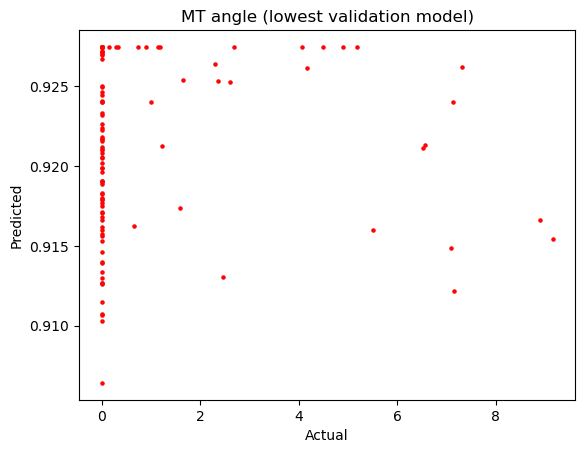

In [159]:
# plot MT value

predicted_mt = [item[0] for item in MT_value_best]
true_mt = [item[1] for item in MT_value_best]

plt.scatter(true_mt, predicted_mt, color='#fc0505', s=5)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('MT angle (lowest validation model)')
plt.show()

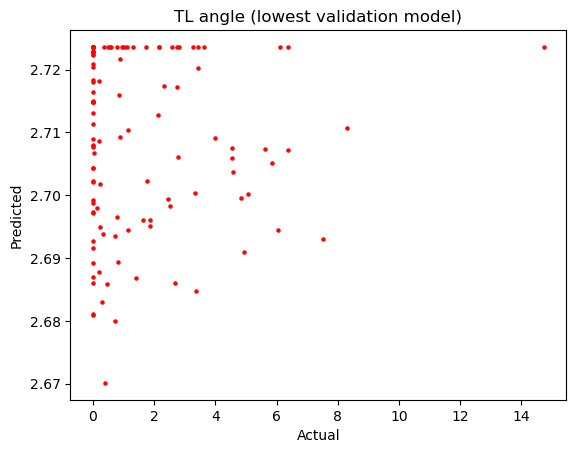

In [160]:
# plot TL value
predicted_tl = [item[0] for item in TL_value_best]
true_tl = [item[1] for item in TL_value_best]

plt.scatter(true_tl, predicted_tl, color='#fc0505', s=5)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('TL angle (lowest validation model)')
plt.show()

#### Evaluation metrics

In [123]:
# finished model
# PT
true_PT_final = [element[1] for element in PT_value_final]
pred_PT_final = [element[0] for element in PT_value_final]

# MT
true_MT_final = [element[1] for element in MT_value_final]
pred_MT_final = [element[0] for element in MT_value_final]

# TL
true_TL_final = [element[1] for element in TL_value_final]
pred_TL_final = [element[0] for element in TL_value_final]


# best model
# PT
true_PT_best = [element[1] for element in PT_value_best]
pred_PT_best = [element[0] for element in PT_value_best]

# MT
true_MT_best = [element[1] for element in MT_value_best]
pred_MT_best = [element[0] for element in MT_value_best]

# TL
true_TL_best = [element[1] for element in TL_value_best]
pred_TL_best = [element[0] for element in TL_value_best]

##### R Square/Adjusted R Square

In [124]:
# for finished_model
from sklearn.metrics import r2_score

# PT
r2_PT_fin = r2_score(true_PT_final, pred_PT_final)
print('R Square score for PT (finished model) ', r2_PT_fin)

# MT
r2_MT_fin = r2_score(true_PT_final, pred_PT_final)
print('R Square score for MT (finished model) ', r2_MT_fin)

# TL
r2_TL_fin = r2_score(true_TL_final, pred_TL_final)
print('R Square score for TL (finished model) ', r2_TL_fin)

R Square score for PT (finished model)  -0.1496049245756903
R Square score for MT (finished model)  -0.1496049245756903
R Square score for TL (finished model)  -0.34384352744302427


In [125]:
# for the best model

# PT
r2_PT_best = r2_score(true_PT_best, pred_PT_best)
print('R Square score for PT (best model) ', r2_PT_fin)

# MT
r2_MT_best = r2_score(true_PT_best, pred_PT_best)
print('R Square score for MT (best model) ', r2_MT_fin)

# TL
r2_TL_best = r2_score(true_TL_best, pred_TL_best)
print('R Square score for TL (best model) ', r2_TL_fin)

R Square score for PT (best model)  -0.1496049245756903
R Square score for MT (best model)  -0.1496049245756903
R Square score for TL (best model)  -0.34384352744302427


In [126]:
# manual calculation
def r2(true, pred):
    true_mean = sum(true) / len(true)
    
    ssr = sum((true[i] - pred[i])**2 for i in range(len(true)))
    sst = sum((true[i] - true_mean)**2 for i in range(len(true)))
    r_squared = 1 - (ssr / sst)
    return r_squared

##### Residual Standard Error of the Regression

In [127]:
import numpy as np
from sklearn.metrics import mean_squared_error

def RSE(true, predict):

    # Calculate the residuals
    residuals = np.array(true) - np.array(predict)

    # Compute the sum of squared residuals
    ssr = np.sum(residuals**2)

    # Calculate the RSE
    n = len(true)  # Total number of observations
    p = 1  # Number of model parameters (including intercept, if applicable)
    rse = np.sqrt(ssr / (n - p))

    return rse

In [128]:
# for finished model
# PT
print('RSE PT (finished) ', RSE(true_PT_final, pred_PT_final))

# MT
print('RSE PT (finished) ', RSE(true_MT_final, pred_MT_final))

# TL
print('RSE PT (finished) ', RSE(true_TL_final, pred_TL_final))


RSE PT (finished)  4.5106639526886045
RSE PT (finished)  2.055515896600724
RSE PT (finished)  2.615887338176787


In [129]:
# for best model
# PT
print('RSE PT (finished) ', RSE(true_PT_best, pred_PT_best))

# MT
print('RSE PT (finished) ', RSE(true_MT_best, pred_MT_best))

# TL
print('RSE PT (finished) ', RSE(true_TL_best, pred_TL_best))


RSE PT (finished)  4.5106639526886045
RSE PT (finished)  2.055515896600724
RSE PT (finished)  2.615887338176787
